In [1]:
import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
from cycler import cycler

from scipy.optimize import minimize

from scipy.stats import norm

from astropy.io import fits

from coprofile import COGenerator

from likelihood import ModelLikelihood, FunctionModelLikelihood, SampleInverter

import pyunfold as pu

from scipy.ndimage import convolve

In [2]:
colors = mpl.cm.viridis(np.linspace(0., 1., 5))

axes_style = { 'grid'      : 'True',
               'labelsize' : '14',
               'labelpad'  : '8.0',
               'prop_cycle': cycler('color', colors) }
grid_style = { 'alpha'     : '0.75',
               'linestyle' : ':' }
font_style = { 'size'      : '14' }

mpl.rc('font', **font_style)
mpl.rc('axes', **axes_style)
mpl.rc('grid', **grid_style)

In [3]:
fmu_neg, fmu_fast = 0.066, 0.072
f_ratio = fmu_fast/fmu_neg

In [4]:
mu_neg_file, mu_fast_file = 'models/balco_14co_delta_neg_models.fits', 'models/balco_14co_delta_fast_models.fits'

In [5]:
inverter = SampleInverter(f_ratio=f_ratio)

z = inverter.z
t = inverter.t
z_samp = inverter.z_samp
t_samp = inverter.t_samp

In [6]:
interp = np.zeros((len(z[1:]), len(z_samp)))

for j in range(len(z_samp)+1):
    if j == 0:
        bound = z[1:]<=z_samp[j]
        interp[bound, j] += (z[1:][bound]-z[1])/(z_samp[j]-z[1])
        
        #interp[bound, j+1] += (z_samp[j]-z[1:][bound])/(z_samp[j]-z_samp[j+1])
    elif j == len(z_samp):
        bound = z[1:]>=z_samp[j-1]
        interp[bound, j-1] += (z_samp[j-2]-z[1:][bound])/(z_samp[j-2]-z_samp[j-1])
        
        interp[bound, j-2] += (z_samp[j-1]-z[1:][bound])/(z_samp[j-1]-z_samp[j-2])
    else:
        bound = np.logical_and(z[1:]<=z_samp[j], z[1:]>=z_samp[j-1])
        interp[bound, j-1] += (z_samp[j]-z[1:][bound])/(z_samp[j]-z_samp[j-1])
        
        bound = np.logical_and(z[1:]>=z_samp[j-1], z[1:]<=z_samp[j])
        interp[bound, j] += (z_samp[j-1]-z[1:][bound])/(z_samp[j-1]-z_samp[j])

In [7]:
resolve = np.matmul(inverter.comp, np.matmul(inverter.G_inv, interp))

In [8]:
generator = COGenerator(mu_neg_file, mu_fast_file)

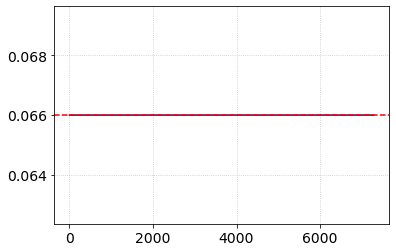

In [9]:
t_scale = (t-t[0])/(t[0]-t[-1])

#amp = 1-0.5*t_scale
#amp = 1-0.1*np.sin(np.pi*t_scale)
amp = np.ones(len(t))

f_neg = fmu_neg*amp
f_fast = fmu_fast*amp

plt.plot(t,f_neg)
plt.axhline(fmu_neg, ls='--', c='red')

In [10]:
# we need to flip f_neg and f_fast because the profile generator doesn't expect time to be in reverse order.
const_profile = generator.generate(f_neg = np.flip(f_neg), f_fast = np.flip(f_fast), rel_uncertainty=0.02)

Text(0.5, 1.0, 'Constant CO Profile Sample')

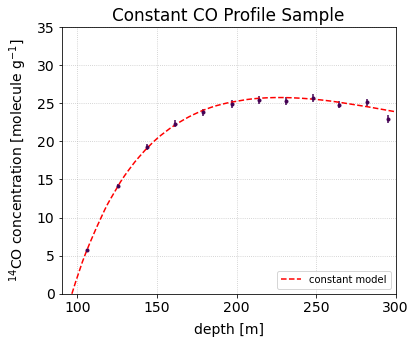

In [11]:
z_samp2, CO_samp, dCO_samp = const_profile.sample_z()

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(const_profile.z, const_profile.CO, 'r--', label='constant model')
ax.errorbar(z_samp2, CO_samp, yerr=dCO_samp, fmt='.')
ax.set(xlim=(90,300),
        xlabel='depth [m]',
        ylim=(0,35),
        ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax.legend(loc='lower right', fontsize=10)
plt.title('Constant CO Profile Sample')

Text(0.5, 1.0, 'CO sample Inverted to f_mu_neg Solution')

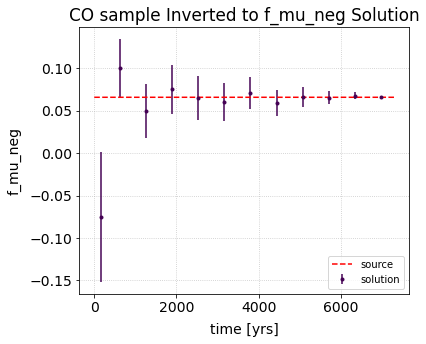

In [12]:
f_solve, df = inverter.solve(CO_samp, dCO_samp)

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(t, f_neg, ls='--', c='red', label='source')
#ax.axhline(0.066, ls='--', c='red', label='source')
ax.errorbar(t_samp, f_solve, yerr=df, fmt='.', label='solution')
ax.set(xlabel='time [yrs]',
        ylabel='f_mu_neg')
ax.legend(loc='lower right', fontsize=10)
plt.title('CO sample Inverted to f_mu_neg Solution')

Text(0.5, 1.0, 'Constant CO Profile Sample w/ Fit')

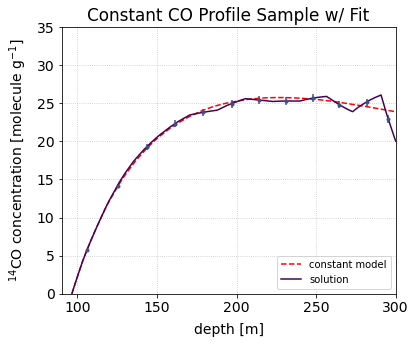

In [13]:
CO_solve = np.matmul(inverter.G, np.matmul(inverter.model, f_solve))

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(const_profile.z, const_profile.CO, 'r--', label='constant model')
ax.plot(inverter.z[1:], CO_solve, label = 'solution')
ax.errorbar(z_samp2, CO_samp, yerr=dCO_samp, fmt='.')
ax.set(xlim=(90,300),
        xlabel='depth [m]',
        ylim=(0,35),
        ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax.legend(loc='lower right', fontsize=10)
plt.title('Constant CO Profile Sample w/ Fit')

In [14]:
const_params = 0.066+np.zeros(12)

B = inverter.likelihood(f_solve, CO_samp, dCO_samp) / inverter.likelihood(const_params, CO_samp, dCO_samp)

print('B_01 = {}'.format(B))

B_01 = 114.57773391622251


Text(0.5, 1.0, 'Constant CO Profile Sample w/ Fits')

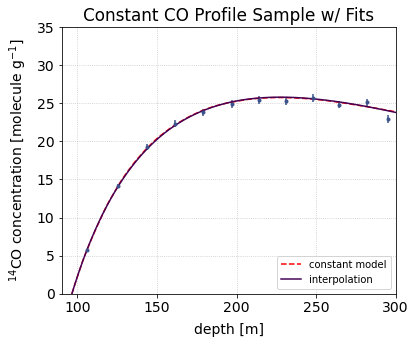

In [15]:
z_scale = (z[1:]-z[0])/(z[-1]-z[0])
a = 37.5 # left-right scaling
b = 140 # slope
c = 0.24 # shape
CO_interp = a*np.log(1+z_scale*b/a)*np.exp(-b*c*z_scale/a)
#CO_interp = np.matmul(interp, CO_samp)

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(const_profile.z, const_profile.CO, 'r--', label='constant model')
ax.plot(z[1:], CO_interp, label = 'interpolation')
#ax.plot(z[1:], CO_solve, c=colors[2], label = 'compressed solution')
ax.errorbar(z_samp2, CO_samp, yerr=dCO_samp, fmt='.')
ax.set(xlim=(90,300),
        xlabel='depth [m]',
        ylim=(0,35),
        ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax.legend(loc='lower right', fontsize=10)
plt.title('Constant CO Profile Sample w/ Fits')

Text(0.5, 1.0, 'Constant CO Profile Sample w/ Fits')

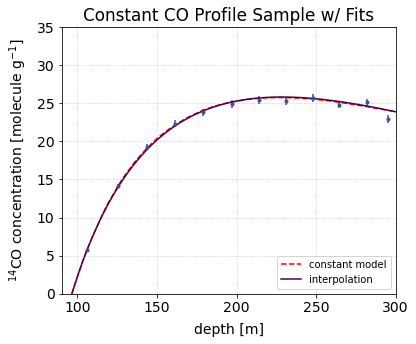

In [16]:
z_scale = (z[1:]-z[0])/(z[-1]-z[0])
a = 38 # shape (up-down)
b = np.diff(const_profile.CO)[0]/np.diff(z_scale)[0] # slope
c = const_profile.CO[-1] # end height
CO_interp = a*np.log(1+z_scale*b/a)*np.exp(-np.log(a*np.log(1+b/a)/c)*z_scale)
#CO_interp = np.matmul(interp, CO_samp)

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(const_profile.z, const_profile.CO, 'r--', label='constant model')
ax.plot(z[1:], CO_interp, label = 'interpolation')
#ax.plot(z[1:], CO_solve, c=colors[2], label = 'compressed solution')
ax.errorbar(z_samp2, CO_samp, yerr=dCO_samp, fmt='.')
ax.set(xlim=(90,300),
        xlabel='depth [m]',
        ylim=(0,35),
        ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax.legend(loc='lower right', fontsize=10)
plt.title('Constant CO Profile Sample w/ Fits')

Text(0.5, 1.0, 'Constant CO Profile Sample w/ Fits')

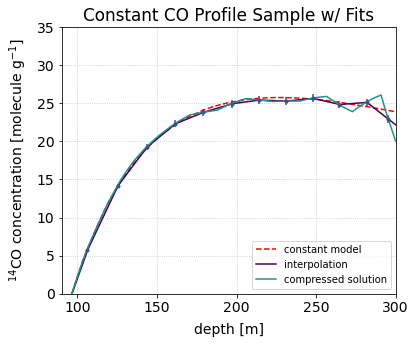

In [17]:
CO_interp = np.matmul(interp, CO_samp)

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(const_profile.z, const_profile.CO, 'r--', label='constant model')
ax.plot(z[1:], CO_interp, label = 'interpolation')
ax.plot(z[1:], CO_solve, c=colors[2], label = 'compressed solution')
ax.errorbar(z_samp2, CO_samp, yerr=dCO_samp, fmt='.')
ax.set(xlim=(90,300),
        xlabel='depth [m]',
        ylim=(0,35),
        ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax.legend(loc='lower right', fontsize=10)
plt.title('Constant CO Profile Sample w/ Fits')

Text(0.5, 1.0, 'CO sample Inverted to f_mu_neg Solution')

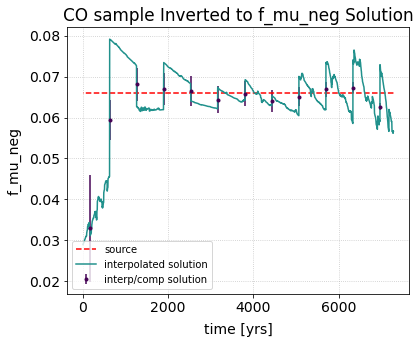

In [18]:
f_supersolve = np.matmul(inverter.G_inv, CO_interp)
f_resolve = np.matmul(inverter.comp, f_supersolve)
df_resolve = np.sqrt(np.sum((resolve * dCO_samp)**2,axis=1))

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(t, f_neg, ls='--', c='red', label='source')
#ax.axhline(0.066, ls='--', c='red', label='source')
ax.plot(t[1:], f_supersolve[1:], c=colors[2], label = 'interpolated solution')
ax.errorbar(t_samp, f_resolve, yerr=df_resolve, fmt='.', label='interp/comp solution')
#ax.errorbar(t_samp, f_solve, yerr=df, c=colors[3], fmt='.', label='compressed solution')
ax.set(xlabel='time [yrs]',
        ylabel='f_mu_neg')
ax.legend(loc='lower left', fontsize=10)
plt.title('CO sample Inverted to f_mu_neg Solution')

Text(0.5, 1.0, 'Constant CO Profile Sample w/ Fit')

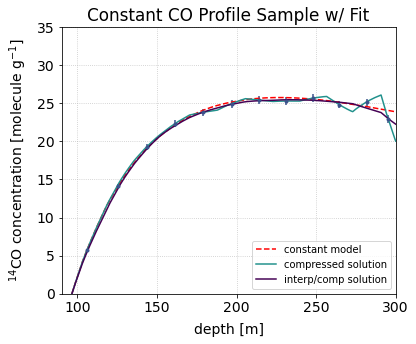

In [19]:
CO_resolve = np.matmul(inverter.G, np.matmul(inverter.model, f_resolve))


fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(const_profile.z, const_profile.CO, 'r--', label='constant model')
ax.plot(inverter.z[1:], CO_solve, c=colors[2], label = 'compressed solution')
ax.plot(inverter.z[1:], CO_resolve, label = 'interp/comp solution')
ax.errorbar(z_samp2, CO_samp, yerr=dCO_samp, fmt='.')
ax.set(xlim=(90,300),
        xlabel='depth [m]',
        ylim=(0,35),
        ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax.legend(loc='lower right', fontsize=10)
plt.title('Constant CO Profile Sample w/ Fit')

In [20]:
const_params = 0.066+np.zeros(12)

B = inverter.likelihood(f_resolve, CO_samp, dCO_samp) / inverter.likelihood(const_params, CO_samp, dCO_samp)

print('B_01 = {}'.format(B))

B_01 = 0.123444944044589


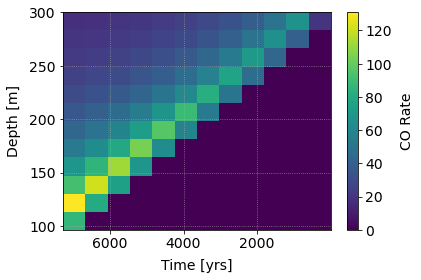

In [21]:
fig, ax = plt.subplots()
im = ax.imshow(inverter.G_comp, origin='lower', extent=[t[0],t[-1],z[0],z[-1]], aspect='auto')
cbar = plt.colorbar(im, label='CO Rate')
ax.set(xlabel='Time [yrs]', ylabel='Depth [m]')
plt.show()

In [22]:
unfolded_results = pu.iterative_unfold(data=CO_samp,
                                    data_err=dCO_samp,
                                    response=inverter.G_comp,
                                    response_err=np.sqrt(abs(inverter.G_comp)),
                                    efficiencies=np.sum(inverter.G_comp, axis=0),
                                    efficiencies_err=np.sum(inverter.G_comp, axis=0)*0.02,
                                    callbacks=[pu.Logger()],
                                    ts_stopping = 0.001)

Iteration 1: ts = 0.0040, ts_stopping = 0.001
Iteration 2: ts = 0.0032, ts_stopping = 0.001
Iteration 3: ts = 0.0027, ts_stopping = 0.001
Iteration 4: ts = 0.0024, ts_stopping = 0.001
Iteration 5: ts = 0.0022, ts_stopping = 0.001
Iteration 6: ts = 0.0020, ts_stopping = 0.001
Iteration 7: ts = 0.0018, ts_stopping = 0.001
Iteration 8: ts = 0.0017, ts_stopping = 0.001
Iteration 9: ts = 0.0016, ts_stopping = 0.001
Iteration 10: ts = 0.0015, ts_stopping = 0.001
Iteration 11: ts = 0.0014, ts_stopping = 0.001
Iteration 12: ts = 0.0013, ts_stopping = 0.001
Iteration 13: ts = 0.0012, ts_stopping = 0.001
Iteration 14: ts = 0.0011, ts_stopping = 0.001
Iteration 15: ts = 0.0011, ts_stopping = 0.001
Iteration 16: ts = 0.0010, ts_stopping = 0.001
Iteration 17: ts = 0.0010, ts_stopping = 0.001


C:\Users\walte\anaconda3\lib\site-packages\pyunfold\mix.py:64: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(cvm.diagonal())


Text(0.5, 1.0, 'CO sample Unfolded to f_mu_neg Solution')

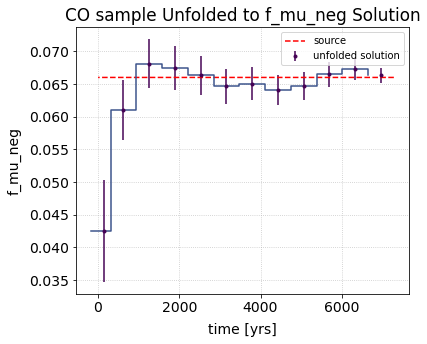

In [23]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(t, f_neg, ls='--', c='red', label='source')
#ax.axhline(0.066, ls='--', c='red', label='source')
#ax.scatter(t_samp, unfolded_results['unfolded'], label='unfolded solution')
ax.errorbar(t_samp, unfolded_results['unfolded'], yerr=unfolded_results['stat_err'], fmt='.', label='unfolded solution')
ax.step(t_samp+np.diff(t_samp)[0]/2, unfolded_results['unfolded'])
#ax.errorbar(t_samp, f_resolve, yerr=df_resolve, fmt='.', label='interp/comp solution')
#ax.errorbar(t_samp, f_solve, yerr=df, c=colors[3], fmt='.', label='compressed solution')
ax.set(xlabel='time [yrs]',
        ylabel='f_mu_neg')
ax.legend(loc='upper right', fontsize=10)
plt.title('CO sample Unfolded to f_mu_neg Solution')

Text(0.5, 1.0, 'CO sample Unfolded to f_mu_neg Solution')

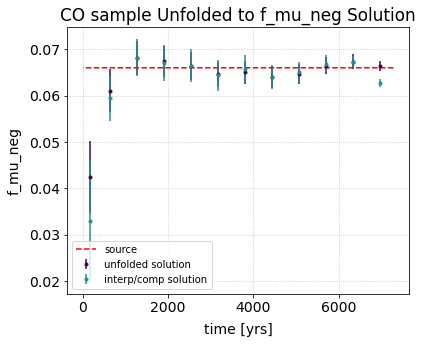

In [24]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
#ax.axhline(0.066, ls='--', c='red', label='source')
ax.plot(t, f_neg, ls='--', c='red', label='source')
#ax.scatter(t_samp, unfolded_results['unfolded'], label='unfolded solution')
ax.errorbar(t_samp, unfolded_results['unfolded'], yerr=unfolded_results['stat_err'], fmt='.', label='unfolded solution')
ax.errorbar(t_samp, f_resolve, yerr=df_resolve, c=colors[2], fmt='.', label='interp/comp solution')
#ax.errorbar(t_samp, f_solve, yerr=df, c=colors[3], fmt='.', label='compressed solution')
ax.set(xlabel='time [yrs]',
        ylabel='f_mu_neg')
ax.legend(loc='lower left', fontsize=10)
plt.title('CO sample Unfolded to f_mu_neg Solution')

Text(0.5, 1.0, 'Constant CO Profile Sample w/ Fit')

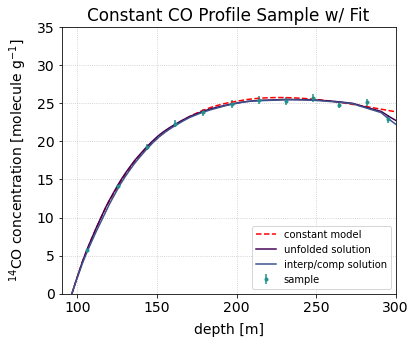

In [25]:
CO_unfold = np.matmul(inverter.G, np.matmul(inverter.model, unfolded_results['unfolded']))


fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(const_profile.z, const_profile.CO, 'r--', label='constant model')
#ax.plot(inverter.z[1:], CO_solve, c=colors[2], label = 'compressed solution')
ax.plot(inverter.z[1:], CO_unfold, label = 'unfolded solution')
ax.plot(inverter.z[1:], CO_resolve, label = 'interp/comp solution')
ax.errorbar(z_samp2, CO_samp, yerr=dCO_samp, fmt='.', label='sample')
ax.set(xlim=(90,300),
        xlabel='depth [m]',
        ylim=(0,35),
        ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax.legend(loc='lower right', fontsize=10)
plt.title('Constant CO Profile Sample w/ Fit')

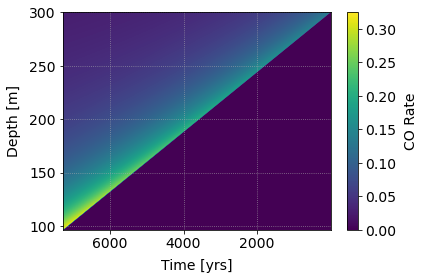

In [26]:
fig, ax = plt.subplots()
im = ax.imshow(inverter.G, origin='lower', extent=[t[0],t[-1],z[0],z[-1]], aspect='auto')
cbar = plt.colorbar(im, label='CO Rate')
ax.set(xlabel='Time [yrs]', ylabel='Depth [m]')
plt.show()

In [27]:
def get_line(vect, delta):
    t_cross = delta/vect
    
    steps = []
    fill = []
    
    t=0
    while t<1:
        i = np.argmin(t_cross)
        if t_cross[i]<1:
            t_new = t_cross[i]
            t_cross[i] += 1/vect[i]
            steps.append(i)
        else:
            t_new = 1
        
        fill.append(t_new-t)
        t = t_new
    return np.array(steps), np.array(fill)

In [28]:
def densities(A, N=3):
    dim = np.shape(A)[0]
    
    cell_size = np.sum(A,axis=1)/(N-1)
    cols = (A/np.expand_dims(cell_size, axis=1)).T
    
    dense = np.zeros((N,)*dim)
    x = np.zeros(dim)
    cell = np.floor(x+0.5).astype(int)
    dense[tuple(cell)] += 1
    
    dense = np.flip(dense)
    
    for v in tqdm(cols):
        cell = np.floor(x+0.5)
        delta = cell+0.5 - x
        if np.any(v > delta):
            steps, fill = get_line(v, delta)
            weights = np.zeros(np.bincount(np.append(steps,np.arange(dim))))
            rel_cell = np.zeros(dim, dtype=int)
            weights[tuple(rel_cell)] = 1/len(fill)#fill[0]
            for i,s in enumerate(steps):
                rel_cell[s] += 1
                weights[tuple(rel_cell)] = 1/len(fill)#fill[i+1]
            dense = convolve(dense, np.flip(weights), mode='constant')
        x += v
        
    return np.flip(dense), cell_size

In [37]:
N = 5
A = np.matmul(inverter.comp, inverter.G)

In [30]:
dense, cell_size = densities(A, N)

  7%|█████▉                                                                         | 544/7283 [00:14<02:35, 43.22it/s]C:\Users\walte\AppData\Local\Temp/ipykernel_14100/4051768740.py:2: RuntimeWarning: divide by zero encountered in true_divide
  t_cross = delta/vect
100%|██████████████████████████████████████████████████████████████████████████████| 7283/7283 [01:16<00:00, 95.48it/s]


In [31]:
logd = np.log(dense)

In [106]:
f_0 = 0*t + fmu_neg
f_bound = 1*fmu_neg

CO_0 = np.matmul(A, f_0 - f_bound)
CO_step = cell_size * f_bound * 2

In [107]:
np.min(dense)

3.552713678800501e-15

CO Sample Probability: 5.967194738332182e-09


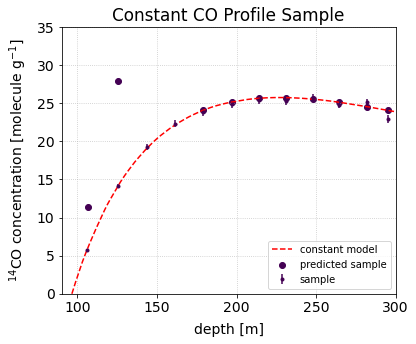

In [108]:
cell = np.array([2,2,2,2,0,0,0,0,0,0,0,0])+2

CO_cell = CO_0 + CO_step * cell

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(const_profile.z, const_profile.CO, 'r--', label='constant model')
ax.scatter(z_samp, CO_cell, label='predicted sample')
ax.errorbar(z_samp2, CO_samp, yerr=dCO_samp, fmt='.', label='sample')
ax.set(xlim=(90,300),
        xlabel='depth [m]',
        ylim=(0,35),
        ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax.legend(loc='lower right', fontsize=10)
plt.title('Constant CO Profile Sample')

print('CO Sample Probability: {}'.format(dense[tuple(cell)]))

In [109]:
CO_off = (CO_samp - CO_0)/dCO_samp
CO_mod = CO_step/dCO_samp

In [110]:
cells = np.meshgrid(*(np.arange(N),)*12, sparse=True)

In [111]:
p = np.sum(np.exp(logd - sum([(CO_off[i] - cells[i]*CO_mod[i])**2 for i in range(len(cells))])/2)) / np.sqrt((2*np.pi)**12) * np.prod(CO_mod)
print(p)

65657.3907961491


In [112]:
np.exp(-np.sum(((CO_samp - np.matmul(inverter.comp, const_profile.CO[1:]))/dCO_samp)**2)/2) / np.sqrt((2*np.pi)**12) / np.prod(dCO_samp)

0.006862459784499555

In [402]:
f_0 = 0*t + fmu_neg
f_bound = 0.001*fmu_neg

f_cov = np.diag(np.full(len(t), f_bound**2))

In [403]:
M_cov = np.matmul(A, np.matmul(f_cov, A.T)) # model covariance matrix
M_inv = np.linalg.inv(M_cov)

In [404]:
np.sqrt(np.diag(M_cov))

array([0.00025936, 0.00041999, 0.0004583 , 0.00046137, 0.00044996,
       0.00043195, 0.00041086, 0.00038863, 0.00036622, 0.00034418,
       0.00032285, 0.00031342])

In [405]:
S_cov = np.diag(dCO_samp**2) # sample covariance matrix
S_inv = np.linalg.inv(S_cov)

In [406]:
mu = CO_samp - np.matmul(A, f_0)

BIG_matrix = np.linalg.inv(S_cov + M_cov)
#log_det = np.log(np.linalg.det(M_cov)) + np.log(np.linalg.det(S_cov)) + np.log(np.linalg.det(M_inv + S_inv))
log_det = np.log(np.linalg.det(BIG_matrix/2/np.pi))

In [407]:
prob = np.exp( ( log_det - np.matmul(mu, np.matmul(BIG_matrix, mu)) )/2 )

In [408]:
prob

0.006862424819485783